## MSDS 7333 – Unit 4 Case Study
Albert Asuncion, Brian Lee, Ethan Graham, Melina Shulyak

Assignment: Financial Applications of Time Series<br>
* Choose either the Signal Frontier Analysis application or Future Contract Rolling application.
* Use different stocks than those shown in examples.
* Create iPython Notebook, including code, output, and graphics.
* Include an introduction in your notebook to give background on your application.
* Be sure to explain calculations and output in the appropriate places.
* List outside references if used.<br>

Formatting<br>

Case study write-ups are to be “technical report ready,” which basically means that the write-up is suitable for public viewing.

* Your name must be at the beginning of the notebook.
* The notebook should divided into an abstract, an introduction, a methods section, a results section, and a future work/discussion/conclusion section.
* Use an easy-to-read variable-width font (I like Ariel, Helvetica, and Geneva font) with a minimum of 11 point font.
* Relevant code and output must be explained in the notebook as close to the code/output as possible.
* Any graphics generated using the code must be explained in the notebook as close to the graphic as possible.

## Abstract

*Abstract text placeholder*

## Introduction

__History and Origin of Futures.__
Futures trading evolved out of the need for buyers and sellers of goods to mitigate against price volatility and the counterparty risks inherent between parties to a transaction. When a producer of grain expects his crops to grow to maturity at a future time, his foremost concern is a price he can plan for and come harvest the assurance of a buyer for his crop. Thus in 1948, as the Great Lakes became linked to the Mississippi River via railroad and the Illinois-Michigan canal, the Chicago Board of Trade (CBOT) was formed. 

The CBOT provided a mechanism to stabilize prices and regulate trade through the establishment of a grain exchange. It devised and facilitated the trading of futures contracts which were “legally binding agreements to buy and sell a standardized asset on a specific date”. Futures contracts are indispensable instruments behind all trade which have the following key features [1]:

- Standardized contract  - Making contract specifications identical across participants allows for trading these instruments easily transferable. As a result, the only variable is price, everything else such as the quality, quantity, physical delivery time and location are stipulated but standardized for all participants.
- Exchange-traded - By establishing an exchange, counterpart risks are eliminated and parties have assurance that contracts are backed up by the exchange. Buyers and sellers transact anonymously on a platform where they are brought together to operate with ease in a highly liquid and optimized market.

__Workings of a Trade.__ In a futures contract, the "forward price" is predeterimed for a time in the future, hence the coloquial term "futures" to refer to the trading of these derivative products. In other words, buyer and seller agree on a future price based on both speculating that upon time of settlement, i.e. delivery date, the instrument will yield a profit. 
The market's "invisible hand" establishes the optimum price that provides sellers a hedge against price risk and speculators seeking to make a profit by predicting the price direction [2]. Upon expiration of a contract, a futures trader has 3 options [1]:

1. Settlement - The most obvious course of action is for the trader who is selling (short position) to deliver the asset and/or for the buyer (long position) to pay cash. 
2. Rollover - In rollover, the trader opts to offset an expiring current position for a new position in the next contract month. 
3. Offset the Position - The trader takes and equal and opposite transaction to neutralize te trade.

# Methods

## Future Contract Rolling application

__Preparation for Analysis.__ Using the Pandas, Numpy, datetime, and Pyplot modules, analysis will be performed by the leveraging the cabilities of the APIs to pull, QQQ

In [2]:
from __future__ import division
from pandas import Series, DataFrame
import pandas as pd
from numpy.random import randn
import numpy as np
pd.options.display.max_rows = 12
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 6))

In [3]:
%matplotlib inline

In [4]:
%pwd

u'C:\\Users\\thisi\\Documents\\GitHub\\7333-Quant-World'

In [5]:
pd.options.display.max_rows = 10

In [6]:
## Need to run this in the cmd in order to install pandas-datareader
##$ pip install pandas-datareader

We will use scaled prices for the QQQ exchange-traded fund as a proxy for the S&P 500 index:

In [7]:
#import pandas.io.data as web
import pandas_datareader.data as web
#from pandas_datareader import data, wb
# Approximate price of S&P 500 index
px = web.DataReader('QQQ','iex','2017-05-01','2018-05-01')['close'] * 10
px

2y


date
2017-05-01    1360.219
2017-05-02    1362.500
2017-05-03    1358.137
2017-05-04    1358.633
2017-05-05    1363.590
                ...   
2018-04-25    1586.500
2018-04-26    1619.900
2018-04-27    1620.900
2018-04-30    1609.400
2018-05-01    1627.800
Name: close, Length: 253, dtype: float64

In [8]:
len(px)

253

In [9]:
from datetime import datetime
expiry = {'ESU2': datetime(2018, 9, 21),
          'ESZ2': datetime(2018, 12, 21)}
expiry = Series(expiry).sort_values()

In [10]:
expiry

ESU2   2018-09-21
ESZ2   2018-12-21
dtype: datetime64[ns]

In [11]:
#Project 200 records after the last date the the dataset. Simulate 200 numbers for the last 200 days.
np.random.seed(12347)
N = 200
walk = (np.random.randint(0, 200, size=N) - 100) * 0.25
perturb = (np.random.randint(0, 20, size=N) - 10) * 0.25
walk = walk.cumsum()

rng = pd.date_range(px.index[0], periods=len(px) + N, freq='B')
near = np.concatenate([px.values, px.values[-1] + walk])
far = np.concatenate([px.values, px.values[-1] + walk + perturb])
prices = DataFrame({'ESU2': near, 'ESZ2': far}, index=rng)

In [14]:
# now 453 records adding the 200 project records from the previous line of code
len(prices)

453

In [12]:
prices.tail()

,ESU2,ESZ2
2019-01-17,1657.05,1658.80
2019-01-18,1643.30,1645.55
2019-01-21,1651.30,1653.05
2019-01-22,1667.80,1667.05
2019-01-23,1647.80,1645.55


In [15]:
def get_roll_weights(start, expiry, items, roll_periods=5):
    # start : first date to compute weighting DataFrame
    # expiry : Series of ticker -> expiration dates
    # items : sequence of contract names

    dates = pd.date_range(start, expiry[-1], freq='B')
    weights = DataFrame(np.zeros((len(dates), len(items))),
                        index=dates, columns=items)

    prev_date = weights.index[0]
    for i, (item, ex_date) in enumerate(expiry.iteritems()):
        if i < len(expiry) - 1:
            weights.ix[prev_date:ex_date - pd.offsets.BDay(), item] = 1
            roll_rng = pd.date_range(end=ex_date - pd.offsets.BDay(),
                                     periods=roll_periods + 1, freq='B')

            decay_weights = np.linspace(0, 1, roll_periods + 1)
            weights.ix[roll_rng, item] = 1 - decay_weights
            weights.ix[roll_rng, expiry.index[i + 1]] = decay_weights
        else:
            weights.ix[prev_date:, item] = 1

        prev_date = ex_date

    return weights

In [19]:
weights

,ESU2,ESZ2
2018-03-01,1.0,0.0
2018-03-02,1.0,0.0
2018-03-05,1.0,0.0
2018-03-06,1.0,0.0
2018-03-07,1.0,0.0
...,...,...
2018-12-17,0.0,1.0
2018-12-18,0.0,1.0
2018-12-19,0.0,1.0
2018-12-20,0.0,1.0


In [26]:
weights = get_roll_weights('5/1/2017', expiry, prices.columns)
weights.loc['2018-09-12':'2018-09-21']

C:\Users\thisi\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


,ESU2,ESZ2
2018-09-12,1.0,0.0
2018-09-13,1.0,0.0
2018-09-14,0.8,0.2
2018-09-17,0.6,0.4
2018-09-18,0.4,0.6
2018-09-19,0.2,0.8
2018-09-20,0.0,1.0
2018-09-21,0.0,1.0


In [27]:
rolled_returns = (prices.pct_change() * weights).sum(1)

In [28]:
prices.pct_change()

,ESU2,ESZ2
2017-05-01,NaN,NaN
2017-05-02,0.001677,0.001677
2017-05-03,-0.003202,-0.003202
2017-05-04,0.000365,0.000365
2017-05-05,0.003649,0.003649
...,...,...
2019-01-17,0.009596,0.011278
2019-01-18,-0.008298,-0.007988
2019-01-21,0.004868,0.004558
2019-01-22,0.009992,0.008469


In [23]:
weights

,ESU2,ESZ2
2018-03-01,1.0,0.0
2018-03-02,1.0,0.0
2018-03-05,1.0,0.0
2018-03-06,1.0,0.0
2018-03-07,1.0,0.0
...,...,...
2018-12-17,0.0,1.0
2018-12-18,0.0,1.0
2018-12-19,0.0,1.0
2018-12-20,0.0,1.0


In [29]:
#
rolled_returns

2017-05-01    0.000000
2017-05-02    0.001677
2017-05-03   -0.003202
2017-05-04    0.000365
2017-05-05    0.003649
                ...   
2019-01-17    0.000000
2019-01-18    0.000000
2019-01-21    0.000000
2019-01-22    0.000000
2019-01-23    0.000000
Freq: B, Length: 453, dtype: float64

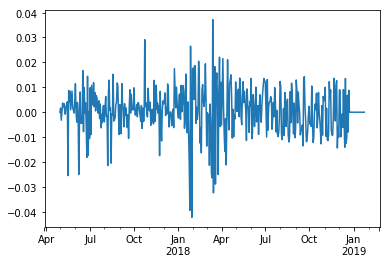

In [33]:
rolled_returns.plot()

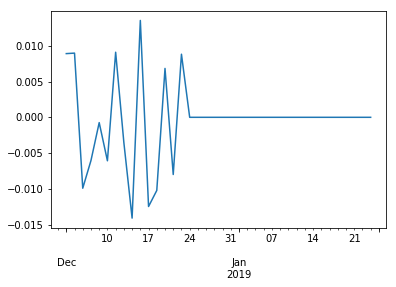

In [32]:
rolled_returns['2018-12-01':'2019-01-23'].plot()

## Results

*Results text placeholder*

__Future Work/Discussion/Conclusion__

*Conclusion text placeholder*

__Bibliiography__

[1] https://institute.cmegroup.com/courses/introduction-to-futures-html<br>
[2] https://en.wikipedia.org/wiki/Futures_contract